<h3>Dependencies

In [1]:
import sys, os

filePath = "F:\\TUDelft\\ResearchAssistant\\research\\code\\current\\RK4_SinDy_packages"
sys.path.insert(0, filePath)

import numpy as np
import torch as T
import os
from scipy.integrate import solve_ivp
from dataclasses import dataclass
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import pysindy as ps
import polynomial_library_torch as pl_torch
from utils import printing_learned_model
from modules import coeffs_dictionary
from models import sdof_free_vibr, sdof_harmonic, sdof_friction
from learning_models import learning_sparse_model
from IPython.utils.io import Tee
from contextlib import closing
import tikzplotlib

<h4> Random Seed

In [2]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

<h3> Parameters

In [14]:
@dataclass
class parameters:
    bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    # save_model_path: str = "./Results/SDOF_free_vibration/"
    save_model_path: str = "./Results/Refactored/"
    weightdecay: float = 0.0
    NumInitial: int = 1
    dim_x: int = 2
    timefinal: float = 50.0
    timestep: float = 1e-1
    normalize: bool = False
    tol_coeffs: float = 5e-2
    poly_order: int = 2
    tikz_save: bool = False
    noise_level: float = 1e-1
    model: str = "friction" # "free", "forced", "friction"
    forcing_freq: float = 1.2
    friction_ratio: float = 0.2
    
Params = parameters()

os.makedirs(os.path.dirname(Params.save_model_path), exist_ok=True)

<h4>Model

In [13]:
if Params.model == "free":
    dynModel = sdof_free_vibr
elif Params.model == "forced":
    dynModel = sdof_harmonic
elif Params.model == "friction":
    dynModel = sdof_friction

<h4> Logging

In [5]:
with closing(
    Tee(
        # f"{Params.save_model_path}Noisy_SDOF_free_vibration.log",
        # f"{Params.save_model_path}Noisy_SDOF_Harmonic_Excitation.log",
        f"{Params.save_model_path}Noisy_SDOF_Friction.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    
    print(f"\n{'*'*100}")
    print(f"{'*'*10} TIME STEP {parameters.timestep:.3f} {'*'*10}")
    print(f"{10*'*'} POLYNOMIAL ORDER {parameters.poly_order:.0f} {10*'*'}")
    print(f"{10*'*'} NOISE LEVEL {parameters.noise_level:.3f} {10*'*'}")
    if parameters.model == "friction":
        print(f"{10*'*'} FRICTION TO FORCE RATIO {parameters.friction_ratio:.2f} {10*'*'}")
    if parameters.model == "friction" or Params.model == "forced":
        print(f"{10*'*'} FORCING FREQUENCY {parameters.forcing_freq:.2f} {10*'*'}")


****************************************************************************************************
********** TIME STEP 0.100 **********
********** POLYNOMIAL ORDER 2 **********
********** NOISE LEVEL 0.050 **********
********** FRICTION TO FORCE RATIO 0.50 **********
********** FORCING FREQUENCY 1.20 **********


In [15]:
ts = np.arange(0, Params.timefinal, Params.timestep)

filtered_ts = np.sort(np.random.choice(ts, size=(300,), replace=False))

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
if Params.model == "friction":
    # sol = solve_ivp(lambda t, x: dynModel(x, t, friction_force_ratio=Params.friction_ratio, forcing_freq=Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
    sol = solve_ivp(lambda t, x: dynModel(x, t, friction_force_ratio=Params.friction_ratio, forcing_freq=Params.forcing_freq), t_span=[filtered_ts[0], filtered_ts[-1]], y0=x0, t_eval=filtered_ts)
elif Params.model == "forced":
    sol = solve_ivp(lambda t, x: dynModel(x, t, Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=filtered_ts)
    # sol = solve_ivp(lambda t, x: dynModel(x, t, Params.forcing_freq), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
else:
    # sol = solve_ivp(lambda t, x: dynModel(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts)
    sol = solve_ivp(lambda t, x: dynModel(x, t), t_span=[ts[0], ts[-1]], y0=x0, t_eval=filtered_ts)
x = np.transpose(sol.y)

# Generate noisy measurements
x = np.random.normal(loc=x, scale=Params.noise_level * np.abs(x), size=x.shape)

In [16]:
# Define dataloaders
train_dset = T.tensor(x).float()
# times = T.tensor(ts).unsqueeze(1).float()
times = T.tensor(filtered_ts).unsqueeze(1).float()

# defining library
funs_dictionary = pl_torch.PolynomialLibrary(degree=Params.poly_order)
funs_dictionary.fit(x)
funs_dictionary_size = funs_dictionary.transform(x).shape[1]

Coeffs = coeffs_dictionary(funs_dictionary_size, Params.dim_x)

# Learning Coefficients
Coeffs, loss_track = learning_sparse_model(funs_dictionary, Coeffs, train_dset, times, Params, quite=True)
Learned_Coeffs = Coeffs.linear.weight.detach().clone().t().numpy()

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 1.09e-01] [Learning rate: 1.00e-04]

In [17]:
printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())

dx0'= -0.075 x0 + 0.985 x1 
dx1'= -0.988 x0 + -0.113 x1 


In [18]:
# Simulate all identified model
# learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).reshape(-1,)
# learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).reshape(-1,) + np.array([0, np.cos(Params.forcing_freq * t)])
learnt_deri = lambda t, z: (funs_dictionary.transform(np.expand_dims(z, axis=0)) @ Learned_Coeffs).squeeze(0) + np.array([0, - Params.friction_ratio * np.sign(z[1]) + np.cos(Params.forcing_freq * t)])

ts_refine = np.arange(0, Params.timefinal, 1e-2)

sol = solve_ivp(lambda t, x: dynModel(x, t, friction_force_ratio=Params.friction_ratio, forcing_freq=Params.forcing_freq), [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine)
x_refine = np.transpose(sol.y)

sol_learnt = solve_ivp(learnt_deri, [ts_refine[0], ts_refine[-1]], x0, t_eval=ts_refine,)
x_learnt = np.transpose(sol_learnt.y)

<h3>Plotting

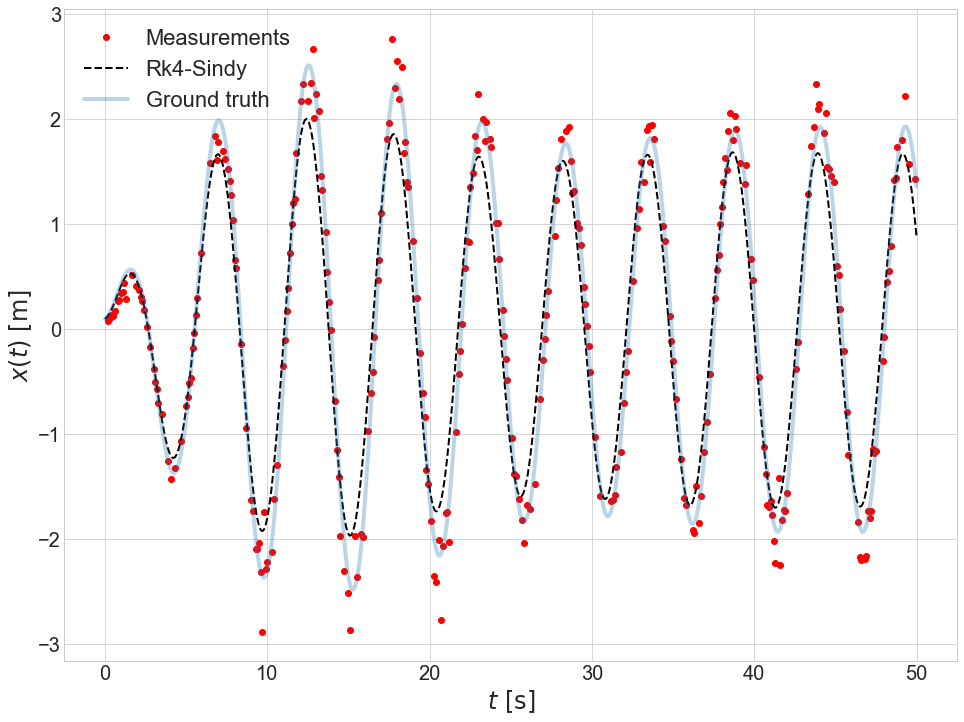

In [19]:
plt.figure(figsize=(16,12))

# plt.plot(ts, x[:, 0], "ro", markersize=6, label="Measurements")
plt.plot(filtered_ts, x[:, 0], "ro", markersize=6, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 0], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 0], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1., 0.6))#, loc='upper right')
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$x(t) \, \, \mathrm{[m]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

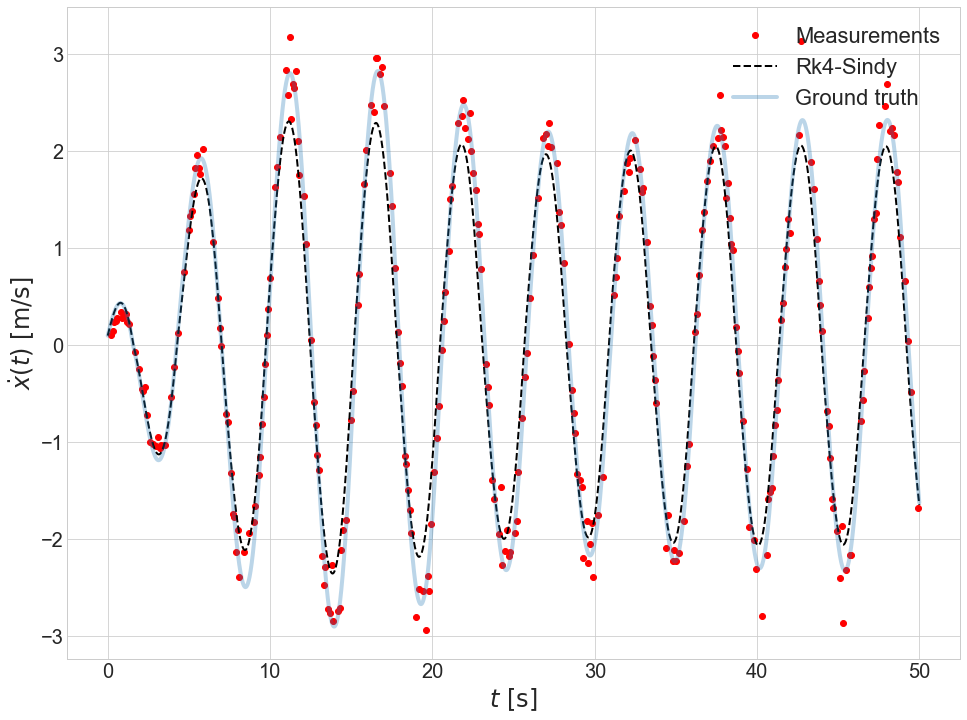

In [20]:
plt.figure(figsize=(16,12))

# plt.plot(ts, x[:, 1], "ro", markersize=6, label="Measurements")
plt.plot(filtered_ts, x[:, 1], "ro", markersize=6, label="Measurements")
plt.plot(ts_refine, x_learnt[:, 1], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts_refine, x_refine[:, 1], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$\dot{x}(t) \, \, \mathrm{[m/s]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

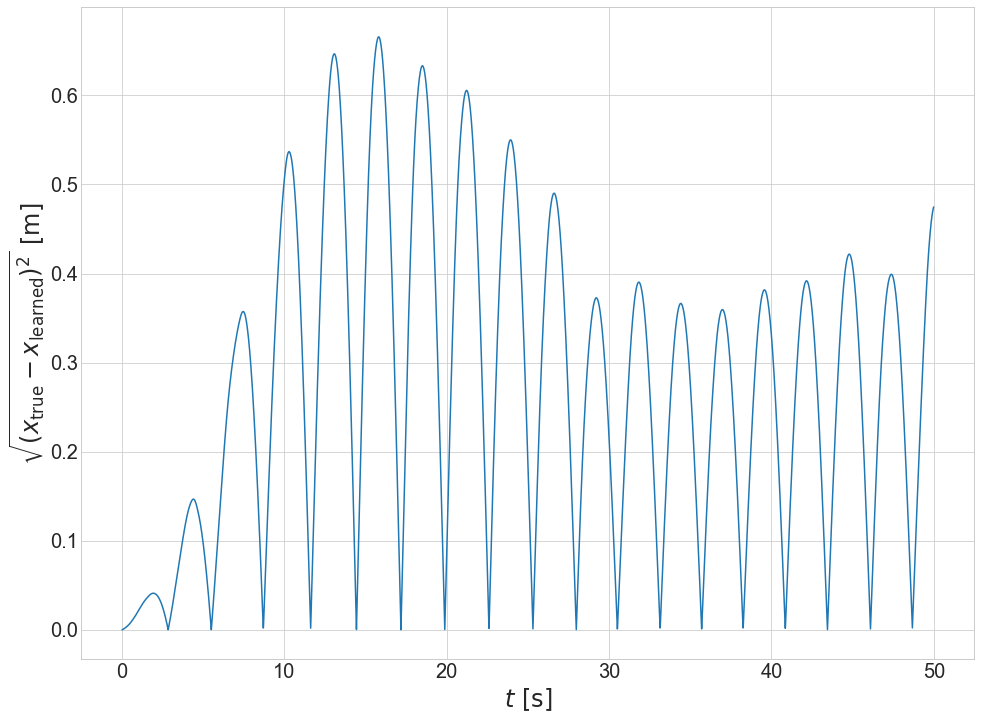

In [27]:
ind = 0

relError = np.abs((x_refine[:, ind] - x_learnt[:, ind]) / x_refine[:, ind])
squaredError = np.sqrt((x_refine[:, ind] - x_learnt[:, ind]) ** 2)

plt.figure(figsize=(16,12))

# plt.plot(ts_refine, relError, label='Relative Error')
plt.plot(ts_refine, squaredError)


# plt.yscale("log")

# plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))

plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
# plt.ylabel(r"$\mid \frac{x_{\mathrm{true}} - x_{\mathrm{learned}}}{x_{\mathrm{true}}} \mid \, \, \mathrm{[-]}$", fontsize=24)
# plt.ylabel(r"$\mid \frac{\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}}{\dot{x}_{\mathrm{true}}} \mid \, \, \mathrm{[-]}$", fontsize=24)
# plt.ylabel(r"$\sqrt{(\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}) ^2} \, \, \mathrm{[m/s]}$", fontsize=24)
plt.ylabel(r"$\sqrt{(x_{\mathrm{true}} - x_{\mathrm{learned}}) ^2} \, \, \mathrm{[m]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


<h4> Logging

In [14]:
with closing(
    Tee(
        # f"{Params.save_model_path}Noisy_SDOF_free_vibration.log",
        # f"{Params.save_model_path}Noisy_SDOF_harmonic_excitation.log",
        f"{Params.save_model_path}Noisy_SDOF_Friction.log",
        "a+",
        channel="stdout",
    )
) as outputstream:
    # printing of the learned sparse models in a file
    print(f"{'='*50}\nRK4 Inspired Methods Sparse Identification")
    printing_learned_model(Learned_Coeffs, funs_dictionary.get_feature_names())
    # print(f"{'='*50}\nSindy Approach")
    # model.print()
    print(f"{'='*50}\n{'*'*100}")


RK4 Inspired Methods Sparse Identification
dx0'= 0.745 x1 + 0.172 x0 x1 
dx1'= -0.991 x0 + -0.115 x0^2 + -0.151 x0 x1 
****************************************************************************************************


(100,)